In [1]:
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import generator
import keras
import edward as ed
import numpy as np
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli
import pickle
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
ed.set_seed(100)
M = 10000
(x_train, _), (x_test, _) = mnist('./data')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_generator = generator(x_train, M)

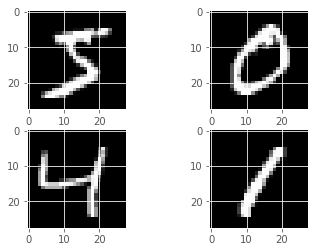

In [3]:
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(x_train[i,:].reshape(28,28),cmap = 'gray')
plt.show()

In [4]:
sess = tf.InteractiveSession()
def auto_encoder(x, W_encode, W_decode, b_endoce, b_decode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    h = tf.matmul(h,W_decode) + b_decode
    return h

In [5]:
W_encode = Normal(loc = tf.zeros([28*28, 256]), scale = tf.ones([28*28, 256]))
W_decode = Normal(loc = tf.zeros([256, 28*28]), scale = tf.ones([256,28*28]))
b_encode = Normal(loc = tf.zeros(256), scale = tf.ones(256))
b_decode = Normal(loc = tf.zeros(28*28), scale = tf.ones(28*28))

x = tf.placeholder(tf.float32, [None, 28 * 28])

x_reconstruct = Normal(loc=auto_encoder(x, W_encode, W_decode, b_encode, b_decode),
                      scale = 0.1 *tf.ones([28*28]))


In [6]:
qW_encode = Normal(loc = tf.Variable(tf.random_normal([28*28,256])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28,256]))))
qW_decode = Normal(loc = tf.Variable(tf.random_normal([256,28*28])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256,28*28]))))
qb_encode = Normal(loc = tf.Variable(tf.random_normal([256])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
qb_decode = Normal(loc = tf.Variable(tf.random_normal([28*28])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28]))))


In [7]:
reconstruct = tf.stack([auto_encoder(x,qW_encode.sample(), 
                                   qW_decode.sample(), qb_encode.sample(), 
                                   qb_decode.sample()) 
                          for _ in range(4)])
tf.global_variables_initializer().run()
out = sess.run(reconstruct, feed_dict = {x: x_train})


(4, 60000, 784)


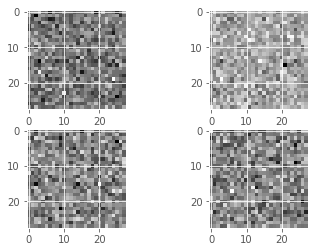

In [8]:
print(out.shape)
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()


In [9]:
inference = ed.KLqp({W_encode:qW_encode, b_encode:qb_encode,
                    W_decode:qW_decode, b_decode:qb_decode}, data = {x: x_train, x_reconstruct: x_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()


In [10]:
n_epoch = 100
n_iter_per_epoch = x_train.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x: x_batch, x_reconstruct: x_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(-avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))
    

Epoch: 1
6/6 [100%] ██████████████████████████████ Elapsed: 63s
-log p(x) <= 2110309524.821
Epoch: 2
6/6 [100%] ██████████████████████████████ Elapsed: 59s
-log p(x) <= 1517733.197
Epoch: 3
6/6 [100%] ██████████████████████████████ Elapsed: 59s
-log p(x) <= 508910.054
Epoch: 4
6/6 [100%] ██████████████████████████████ Elapsed: 58s
-log p(x) <= 459107.046
Epoch: 5
6/6 [100%] ██████████████████████████████ Elapsed: 59s
-log p(x) <= 414419.221
Epoch: 6
6/6 [100%] ██████████████████████████████ Elapsed: 59s
-log p(x) <= 383187.580
Epoch: 7
6/6 [100%] ██████████████████████████████ Elapsed: 58s
-log p(x) <= 348645.687
Epoch: 8
6/6 [100%] ██████████████████████████████ Elapsed: 59s
-log p(x) <= 322178.953
Epoch: 9
6/6 [100%] ██████████████████████████████ Elapsed: 59s
-log p(x) <= 284394.961
Epoch: 10
6/6 [100%] ██████████████████████████████ Elapsed: 58s
-log p(x) <= 265278.908
Epoch: 11
6/6 [100%] ██████████████████████████████ Elapsed: 59s
-log p(x) <= 235681.975
Epoch: 12
6/6 [100%] ████

6/6 [100%] ██████████████████████████████ Elapsed: 62s
-log p(x) <= 15380.823
Epoch: 95
6/6 [100%] ██████████████████████████████ Elapsed: 61s
-log p(x) <= 15505.878
Epoch: 96
6/6 [100%] ██████████████████████████████ Elapsed: 61s
-log p(x) <= 15771.357
Epoch: 97
6/6 [100%] ██████████████████████████████ Elapsed: 61s
-log p(x) <= 15117.590
Epoch: 98
6/6 [100%] ██████████████████████████████ Elapsed: 63s
-log p(x) <= 15038.766
Epoch: 99
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 15280.895
Epoch: 100
6/6 [100%] ██████████████████████████████ Elapsed: 61s
-log p(x) <= 14876.749


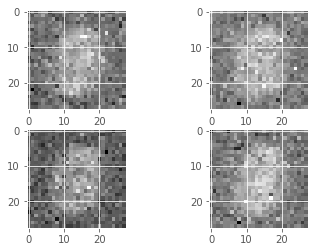

In [11]:
out = sess.run(reconstruct, feed_dict={x: x_train})
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()


In [12]:
encode_weights = qW_encode.sample()
encode_bias = qb_encode.sample()
train_encoded = tf.matmul(x_train, encode_weights) + encode_bias
test_encoded = tf.matmul(x_test, encode_weights) + encode_bias
print(train_encoded.eval().shape)
print(test_encoded.eval().shape)
with open('./data/encoded_train_BAE.pkl','wb') as f:
    pickle.dump(train_encoded.eval(),f)
with open('./data/encoded_test_BAE.pkl','wb') as f:
    pickle.dump(test_encoded.eval(),f)

(60000, 256)
(10000, 256)


[  2.11030952e+09   1.51773320e+06   5.08910054e+05   4.59107046e+05
   4.14419221e+05   3.83187580e+05   3.48645687e+05   3.22178953e+05
   2.84394961e+05   2.65278908e+05   2.35681975e+05   2.20809197e+05
   1.95697357e+05   1.79806065e+05   1.66087503e+05   1.50823827e+05
   1.38646848e+05   1.25075115e+05   1.19100879e+05   1.09521312e+05
   1.01434726e+05   9.61767605e+04   8.83943573e+04   8.24343296e+04
   8.19413600e+04   7.19035819e+04   6.87624704e+04   6.43858763e+04
   5.98508651e+04   5.64396725e+04   5.31317664e+04   5.11731627e+04
   4.78656517e+04   4.50705829e+04   4.38756331e+04   4.14829467e+04
   4.06300251e+04   3.85995104e+04   3.68541552e+04   3.58233840e+04
   3.39894880e+04   3.31910517e+04   3.19581856e+04   3.03804544e+04
   2.98582363e+04   2.87900341e+04   2.77777368e+04   2.67217629e+04
   2.63328795e+04   2.60569571e+04   2.50742432e+04   2.48658413e+04
   2.38107067e+04   2.35739341e+04   2.39497755e+04   2.27532923e+04
   2.18613728e+04   2.19318344e+04

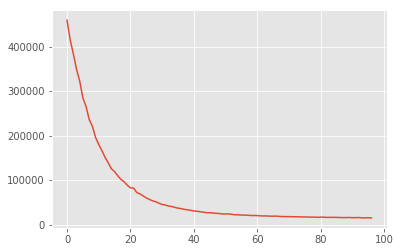

In [25]:
log_loss_temp = np.multiply(log_loss, -1)
print(log_loss_temp)
plt.plot(range(97), log_loss_temp[3:])
plt.show()